In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data("/hpc/group/carin/fk43/FanjieKong/Megapixels/new_tfquantum/quantum/TensorNetwork/mnist.npz")

In [2]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape((60000, 28, 28, 1)).astype(np.float32)
y_train = to_categorical(y_train, 10).astype(np.float32)
x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test, 10)

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(y_train)

In [3]:
xxx_train = (x_train-128)/255
xxx_test = (x_test-128)/255

In [4]:
xx_train = (tf.image.resize(x_train, [16,16]).numpy()-128)/255
xx_test = (tf.image.resize(x_test, [16,16]).numpy()-128)/255

In [5]:
xx_train.shape

(60000, 28, 28, 1)

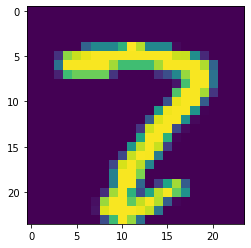

In [49]:
plt.imshow(xx_train[12000,2:-2, 2:-2, :])

In [17]:
class twoDMERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(twoDMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 9
        dims = input_dim
        self.entanglers = []
        self.isometries= []
        for i in range(n_layers):
            if dims % 2 == 0:
                dims = int(dims//2)
                self.entanglers.append([tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=2.0), 
                                              trainable=True) for j in range(dims**2)])
                in_dims = bond_dims
                self.isometries.append([tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=2.0),
                                            trainable=True) for j in range(dims**2)])
                
                
                
        self.final_mps = tf.Variable(tf.random.normal(shape=(bond_dims,)*(dims**2) + (output_dims,)
                                                                 , stddev=2.0))

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers, isometries, final_mps, bias_var, n_layers):
            input_vec = input_vec[2:-2, 2:-2, :]
            input_vv = []
            for i in range(8):
                for ii in range(8):
                    input_vv.append(tf.reshape(input_vec[i*3:i*3+3, ii*3:ii*3+3, 0], (1, 9)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (64, 9))
            input_vec = tf.unstack(input_vec)
            #print(input_vec)
            input_nodes = []
            for e_iv in input_vec:
#                 input_nodes.append(tn.Node(tf.concat([tf.sin(e_iv), tf.cos(e_iv)], axis=0)))
                input_nodes.append(tn.Node(e_iv))

            entangler_nodes_list = []
            for layer in range(self.n_layers):
                entangler_nodes_list_in_one_layer = []
                for idx, e_e in enumerate(entanglers[layer]):
                    entangler_nodes_list_in_one_layer.append(tn.Node(e_e))
                entangler_nodes_list.append(entangler_nodes_list_in_one_layer)
                                     
            isometries_nodes_list = []
            for layer in range(self.n_layers):
                isometries_nodes_list_in_one_layer = []
                for idx, e_i in enumerate(isometries[layer]):
                    isometries_nodes_list_in_one_layer.append(tn.Node(e_i))
                isometries_nodes_list.append(isometries_nodes_list_in_one_layer)
            
            mps_node = tn.Node(final_mps)
            
            
            # Layer 1
            for i in range(4):
                for ii in range(4):
                    entangler_nodes_list[0][4*i+ii][0] ^ input_nodes[0+16*i+2*ii][0]
                    entangler_nodes_list[0][4*i+ii][1] ^ input_nodes[1+16*i+2*ii][0]
                    entangler_nodes_list[0][4*i+ii][2] ^ input_nodes[8+16*i+2*ii][0]
                    entangler_nodes_list[0][4*i+ii][3] ^ input_nodes[9+16*i+2*ii][0]
            
                    entangler_nodes_list[0][4*i+ii][4] ^ isometries_nodes_list[0][4*i+ii][0]
                    entangler_nodes_list[0][4*i+ii][5] ^ isometries_nodes_list[0][4*i+ii][1]
                    entangler_nodes_list[0][4*i+ii][6] ^ isometries_nodes_list[0][4*i+ii][2]
                    entangler_nodes_list[0][4*i+ii][7] ^ isometries_nodes_list[0][4*i+ii][3]
            
            #layer 2
            for i in range(2):
                for ii in range(2):
                    entangler_nodes_list[1][2*i+ii][0] ^ isometries_nodes_list[0][0+8*i+2*ii][4]
                    entangler_nodes_list[1][2*i+ii][1] ^ isometries_nodes_list[0][1+8*i+2*ii][4]
                    entangler_nodes_list[1][2*i+ii][2] ^ isometries_nodes_list[0][4+8*i+2*ii][4]
                    entangler_nodes_list[1][2*i+ii][3] ^ isometries_nodes_list[0][5+8*i+2*ii][4]
            
                    entangler_nodes_list[1][2*i+ii][4] ^ isometries_nodes_list[1][2*i+ii][0]
                    entangler_nodes_list[1][2*i+ii][5] ^ isometries_nodes_list[1][2*i+ii][1]
                    entangler_nodes_list[1][2*i+ii][6] ^ isometries_nodes_list[1][2*i+ii][2]
                    entangler_nodes_list[1][2*i+ii][7] ^ isometries_nodes_list[1][2*i+ii][3]
                    isometries_nodes_list[1][2*i+ii][4] ^ mps_node[2*i+ii] 
                    
            nodes = tn.reachable(mps_node)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers, 
                                                 self.isometries, self.final_mps, self.bias, self.n_layers), inputs)
        return tf.reshape(output, (-1, 10))

In [16]:
class Grid4DMERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(Grid4DMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 16
        dims = input_dim
        self.entanglers = []
        self.isometries= []
        
        #entanglers
        self.entanglers1 = tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        self.entanglers2 = tf.Variable(tf.random.normal
                                             (shape=(bond_dims, bond_dims, 
                                                     bond_dims, bond_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True), 
                           tf.Variable(tf.random.normal(shape=(in_dims, in_dims, bond_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(in_dims, bond_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(bond_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers1, entanglers2, isometries1, isometries2, bias_var, n_layers):
            input_vv = []
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*4:i*4+4, ii*4:ii*4+4, 0], (1, 16)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, 16))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
            e_nodes1 = tn.Node(entanglers1)
            e_nodes2 = tn.Node(entanglers2)
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
            
            e_nodes1[0] ^ input_nodes[5][0]
            e_nodes1[1] ^ input_nodes[6][0]
            e_nodes1[2] ^ input_nodes[9][0]
            e_nodes1[3] ^ input_nodes[10][0]

            e_nodes1[4] ^ isometries_nodes1[0][3]
            e_nodes1[5] ^ isometries_nodes1[1][2]
            e_nodes1[6] ^ isometries_nodes1[2][1]
            e_nodes1[7] ^ isometries_nodes1[3][0]     
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            
            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ e_nodes2[0]
            isometries_nodes1[1][4] ^ e_nodes2[1]
            isometries_nodes1[2][4] ^ e_nodes2[2]
            isometries_nodes1[3][4] ^ e_nodes2[3]

            e_nodes2[4] ^ isometries_nodes2[0]
            e_nodes2[5] ^ isometries_nodes2[1]
            e_nodes2[6] ^ isometries_nodes2[2]
            e_nodes2[7] ^ isometries_nodes2[3]

                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers1, self.entanglers2,
                                                 self.isometries1,  self.isometries2, self.bias, self.n_layers), inputs)
        return tf.reshape(output, (-1, 10))

In [24]:
Dense = tf.keras.layers.Dense

MERA_model = tf.keras.Sequential()
MERA_model.add(tf.keras.Input(shape=(16,16,1)))
MERA_model.add(Grid4DMERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
#MERA_model.add(Dense(10, activation='softmax', name='fc'))
MERA_model.add(tf.keras.layers.Softmax())
#MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera_4 (Grid4DMERA)    (None, 10)                1114538   
_________________________________________________________________
softmax_4 (Softmax)          (None, 10)                0         
Total params: 1,114,538
Trainable params: 1,114,538
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
MERA_hist = MERA_model.fit(xx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 41s 679us/sample - loss: 994391578719796.1250 - accuracy: 0.3690
Epoch 2/50
60000/60000 [==============================] - 37s 613us/sample - loss: 1156218155896476.0000 - accuracy: 0.4946
Epoch 3/50
60000/60000 [==============================] - 32s 531us/sample - loss: 1184583999826445.2500 - accuracy: 0.5523
Epoch 4/50
60000/60000 [==============================] - 32s 529us/sample - loss: 1142528263562164.2500 - accuracy: 0.5932
Epoch 5/50
60000/60000 [==============================] - 31s 522us/sample - loss: 1265903136769520.5000 - accuracy: 0.6189
Epoch 6/50
60000/60000 [==============================] - 31s 523us/sample - loss: 1074394818739140.5000 - accuracy: 0.6500
Epoch 7/50
60000/60000 [==============================] - 31s 522us/sample - loss: 1191770500883214.0000 - accuracy: 0.6661
Epoch 8/50
60000/60000 [==============================] - 32s 525us/sample - loss: 1168405917405177.5000 - acc

KeyboardInterrupt: 

In [ ]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

In [14]:
class Grid4DMERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(Grid4DMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 16
        dims = input_dim
        self.entanglers = []
        self.isometries= []
            
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10000),
                                            trainable=True) for j in range(4)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/1000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, isometries1, isometries2, bias_var, n_layers):
            input_vv = []
            #print(input_vec)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*4:i*4+4, ii*4:ii*4+4, 0], (1, 16)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, 16))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
             
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            input_nodes[5][0] ^ isometries_nodes1[0][3]

            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[6][0] ^ isometries_nodes1[1][2]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]         
            input_nodes[9][0] ^ isometries_nodes1[2][1]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[10][0] ^ isometries_nodes1[3][0]
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ isometries_nodes2[0]
            isometries_nodes1[1][4] ^ isometries_nodes2[1]
            isometries_nodes1[2][4] ^ isometries_nodes2[2]
            isometries_nodes1[3][4] ^ isometries_nodes2[3]
                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.isometries1,  self.isometries2, self.bias, self.n_layers), inputs)
        return tf.reshape(output, (-1, 10))

In [18]:
Dense = tf.keras.layers.Dense

MERA_model = tf.keras.Sequential()
MERA_model.add(tf.keras.Input(shape=(28,28,1)))
MERA_model.add(twoDMERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
#MERA_model.add(Dense(10, activation='softmax', name='fc'))
MERA_model.add(tf.keras.layers.Softmax())
#MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
two_dmera_4 (twoDMERA)       (None, 10)                170       
_________________________________________________________________
softmax_4 (Softmax)          (None, 10)                0         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
MERA_hist = MERA_model.fit(xxx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50


In [67]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
MERA_hist = MERA_model.fit(xx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 329us/sample - loss: 1.5148 - accuracy: 0.5273
Epoch 2/50
60000/60000 [==============================] - 18s 298us/sample - loss: 1.1917 - accuracy: 0.6535
Epoch 3/50
60000/60000 [==============================] - 18s 298us/sample - loss: 1.2757 - accuracy: 0.6247
Epoch 4/50
60000/60000 [==============================] - 18s 298us/sample - loss: 1.1658 - accuracy: 0.6646
Epoch 5/50
60000/60000 [==============================] - 18s 296us/sample - loss: 1.1430 - accuracy: 0.6692
Epoch 6/50
60000/60000 [==============================] - 18s 298us/sample - loss: 1.1260 - accuracy: 0.6725
Epoch 7/50
60000/60000 [==============================] - 18s 299us/sample - loss: 1.1309 - accuracy: 0.6745
Epoch 8/50
60000/60000 [==============================] - 18s 297us/sample - loss: 1.6934 - accuracy: 0.6329
Epoch 9/50
60000/60000 [==============================] - 18s 298us/sample - loss: 1.1716 - accuracy: 0.6

In [12]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 2s 233us/sample - loss: nan - accuracy: 0.0980


[nan, 0.098]

In [68]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 2s 247us/sample - loss: 0.6466 - accuracy: 0.8453


[0.6465772484540939, 0.8453]

In [ ]:
#loss = hist.history['loss']
#acc = hist.history['accuracy']
tn_loss = tn_hist.history['loss']
tn_acc = tn_hist.history['accuracy']

#plt.plot(loss, label='traditional')
plt.plot(tn_loss, label='tn')
plt.title('Loss comparsion in training')
plt.ylim(0, 0.15)
plt.legend()
plt.show()

#plt.plot(acc, label='traditional')
plt.plot(tn_acc, label='tn')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()

In [36]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, dim, n_nodes):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 784), we factorize it into a tensor (, 7, 7, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(7, 7), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(7, 7, 7), stddev=1.0/dim), name="b", trainable=True)
        self.c_var = tf.Variable(tf.random.normal(shape=(16, 16), stddev=1.0/dim), name="b", trainable=True)
        
        self.d_var = tf.Variable(tf.random.normal(shape=(7, 7, 10), stddev=1.0/dim), name="b", trainable=True)
        self.e_var = tf.Variable(tf.random.normal(shape=(7, 16, 10), stddev=1.0/dim), name="b", trainable=True)
        self.f_var = tf.Variable(tf.random.normal(shape=(10, 10, 10), stddev=1.0/dim), name="b", trainable=True)

        self.bias = tf.Variable(tf.zeros(shape=(10)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, c_var, d_var, e_var, f_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (7, 7, 16))
        
            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            c = tn.Node(c_var)
            d = tn.Node(d_var)
            e = tn.Node(e_var)
            f = tn.Node(f_var)
            
            x_node = tn.Node(input_vec)
            a[0] ^ x_node[0]
            b[0] ^ x_node[1]
            c[0] ^ x_node[2]
            a[1] ^ d[0]
            b[1] ^ d[1]
            b[2] ^ e[0]
            c[1] ^ e[1]
            d[2] ^ f[0]
            e[2] ^ f[1]
            

            # The TN should now look like this
            #          |
            #          f
            #       /    \
            #     d       e
            #   /    \ /    \
            #   a     b     c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            #c1 = a @ x_node
            #c2 = c1 @ b
            #c3 = c2 @ c
            #result = c3.tensor
            nodes = tn.reachable(f)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.c_var, 
                                                 self.d_var, self.e_var, self.f_var, self.bias), inputs)
        return tf.reshape(result, (-1, 10))

In [5]:
MERA_model = tf.keras.Sequential()
#MERA_model.add(tf.keras.Input(shape=(8,8,1)))
MERA_model.add(MERA(10,2))
MERA_model.add(tf.keras.layers.Softmax())
MERA_model.build(input_shape=(None, 28, 28, 1))
MERA_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mera (MERA)                  multiple                  3268      
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 3,268
Trainable params: 3,268
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist = MERA_model.fit(xx_train, y_train, epochs=20, verbose=1)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 93us/sample - loss: 2.2900 - accuracy: 0.1211
Epoch 2/20
60000/60000 [==============================] - 4s 62us/sample - loss: 2.2666 - accuracy: 0.1448
Epoch 3/20
60000/60000 [==============================] - 4s 60us/sample - loss: 2.2660 - accuracy: 0.1463
Epoch 4/20
60000/60000 [==============================] - 3s 56us/sample - loss: 2.2660 - accuracy: 0.1477
Epoch 5/20
60000/60000 [==============================] - 3s 56us/sample - loss: 2.2660 - accuracy: 0.1478
Epoch 6/20
60000/60000 [==============================] - 3s 56us/sample - loss: 2.2660 - accuracy: 0.1468
Epoch 7/20
60000/60000 [==============================] - 3s 57us/sample - loss: 2.2660 - accuracy: 0.1466
Epoch 8/20
60000/60000 [==============================] - 4s 62us/sample - loss: 2.2660 - accuracy: 0.1466
Epoch 9/20
23264/60000 [==========>...................] - ETA: 2s - loss: 2.2657 - accuracy: 0.1443

KeyboardInterrupt: 

In [ ]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, dim, n_nodes):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 784), we factorize it into a tensor (, 7, 7, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(7, 7), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(7, 7, 7), stddev=1.0/dim), name="b", trainable=True)
        self.c_var = tf.Variable(tf.random.normal(shape=(16, 16), stddev=1.0/dim), name="b", trainable=True)
        
        self.d_var = tf.Variable(tf.random.normal(shape=(7, 7, 10), stddev=1.0/dim), name="b", trainable=True)
        self.e_var = tf.Variable(tf.random.normal(shape=(7, 16, 10), stddev=1.0/dim), name="b", trainable=True)
        self.f_var = tf.Variable(tf.random.normal(shape=(10, 10, 10), stddev=1.0/dim), name="b", trainable=True)

        self.bias = tf.Variable(tf.zeros(shape=(10)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, c_var, d_var, e_var, f_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (7, 7, 16))
        
            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            c = tn.Node(c_var)
            d = tn.Node(d_var)
            e = tn.Node(e_var)
            f = tn.Node(f_var)
            
            x_node = tn.Node(input_vec)
            a[0] ^ x_node[0]
            b[0] ^ x_node[1]
            c[0] ^ x_node[2]
            a[1] ^ d[0]
            b[1] ^ d[1]
            b[2] ^ e[0]
            c[1] ^ e[1]
            d[2] ^ f[0]
            e[2] ^ f[1]
            

            # The TN should now look like this
            #          |
            #          f
            #       /    \
            #     d       e
            #   /    \ /    \
            #   a     b     c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            #c1 = a @ x_node
            #c2 = c1 @ b
            #c3 = c2 @ c
            #result = c3.tensor
            nodes = tn.reachable(f)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.c_var, 
                                                 self.d_var, self.e_var, self.f_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 10)))